# **PromptAnalyze_DS210** 
### A project to analyze my AI usage



### I had different accounts (3 ChatGPT, 1 Claude) so I combined the data first:

In [39]:
import json
import csv
from datetime import datetime, timezone

# --- Helper: parse timestamps ---
def parse_timestamp(ts):
    """
    Attempts to parse a timestamp that may be ISO 8601 (string) or Unix epoch (int/float).
    Returns a datetime with UTC timezone, or None if parsing fails.
    """
    if isinstance(ts, str):
        # Convert "2024-09-19T06:25:48.927906Z" to a Python datetime
        # Replace trailing 'Z' with '+00:00' so fromisoformat can parse it.
        dt = datetime.fromisoformat(ts.replace('Z', '+00:00'))
        return dt if dt.tzinfo else dt.replace(tzinfo=timezone.utc)
    elif isinstance(ts, (int, float)):
        # Treat as a Unix timestamp
        return datetime.fromtimestamp(ts, tz=timezone.utc)
    return None

# --- Adjust these file lists as needed ---
chatgpt_json_files = [
    "mainAcc.json",
    "suAcc.json",
    "aAcc.json",
]
claude_json_files = [
    "claude_conversations.json"
]

# We’ll store ALL messages (from both ChatGPT & Claude) in one flat list
all_messages = []

# --- Process ChatGPT-like JSON files ---
for filepath in chatgpt_json_files:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
            # Each item in `data` is one chat (conversation)
            for chat in data:
                # Fallback: conversation-level info
                chat_name = chat.get('title') or chat.get('name') or 'Unknown Chat'
                chat_time = parse_timestamp(chat.get('create_time'))
                
                # ChatGPT exports often store messages in `mapping`
                mapping = chat.get('mapping', {})
                for node_id, node_obj in mapping.items():
                    message_obj = node_obj.get('message')
                    if not message_obj:
                        continue
                    
                    # Each message might have its own 'create_time' 
                    # This is the correct, per-message timestamp
                    msg_timestamp = message_obj.get('create_time')
                    parsed_time = parse_timestamp(msg_timestamp) or chat_time
                    
                    content = message_obj.get('content', {})
                    parts = content.get('parts', [])
                    if not parts:
                        continue
                    
                    # Pull first part (typical for ChatGPT)
                    text = parts[0]
                    
                    # Determine sender (system, user, assistant)
                    author = message_obj.get('author', {})
                    sender = author.get('role', 'unknown')
                    
                    # Fall back to "now" if we still have no time
                    if not parsed_time:
                        parsed_time = datetime.now(timezone.utc)
                    
                    all_messages.append({
                        'chat_name': chat_name,
                        'timestamp': parsed_time,
                        'sender': sender,
                        'message': text
                    })
                    
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error reading {filepath}: {e}")

# --- Process Claude-like JSON files ---
for filepath in claude_json_files:
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
            # Each item in `data` is one chat (conversation)
            for chat in data:
                chat_name = chat.get('name', 'Unknown Chat')
                chat_time = parse_timestamp(chat.get('created_at'))
                
                chat_messages = chat.get('chat_messages', [])
                for msg in chat_messages:
                    # Claude messages typically have 'created_at' in ISO 8601
                    msg_time = parse_timestamp(msg.get('created_at'))
                    if not msg_time:
                        # Fallback to conversation-level or UTC now
                        msg_time = chat_time or datetime.now(timezone.utc)
                    
                    sender = msg.get('sender', 'unknown')
                    text = msg.get('text', '')
                    
                    all_messages.append({
                        'chat_name': chat_name,
                        'timestamp': msg_time,
                        'sender': sender,
                        'message': text
                    })
                    
    except (json.JSONDecodeError, FileNotFoundError) as e:
        print(f"Error reading {filepath}: {e}")

# --- Sort ALL messages by their actual timestamps ---
all_messages.sort(key=lambda m: m['timestamp'])

# --- Write out to CSV ---
csv_filename = 'consolidated_chat_history.csv'
with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Chat Name', 'Timestamp', 'Sender', 'Message']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for msg in all_messages:
        writer.writerow({
            'Chat Name': msg['chat_name'],
            'Timestamp': msg['timestamp'].strftime('%Y-%m-%d %H:%M:%S %Z'),
            'Sender': msg['sender'],
            'Message': msg['message']
        })

print(f"Chat history successfully exported to {csv_filename}")


Chat history successfully exported to consolidated_chat_history.csv


# **WORDCLOUDS**

### Here is a wordcloud without removing the stopwords. 
### This one does not really tell us about the data since they are mostly common words like "the, and":

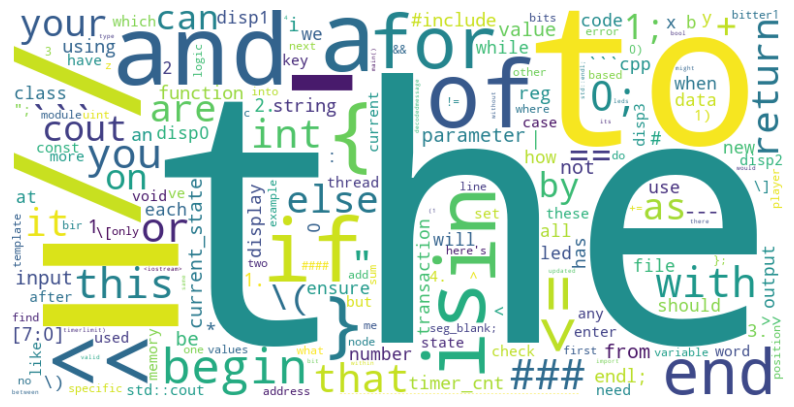

Word cloud successfully generated.


In [40]:
import csv
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Read CSV and extract messages
all_chats = []
with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        all_chats.append(row['Message'])

# Generate word frequency
word_count = defaultdict(int)
for chat in all_chats:
    words = chat.split()
    for word in words:
        word_count[word.lower()] += 1

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print("Word cloud successfully generated.")


### So we remove the stop words and create again:
### And now this data starts telling us something (it tells us that I love C++ as you can see).

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AYB\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


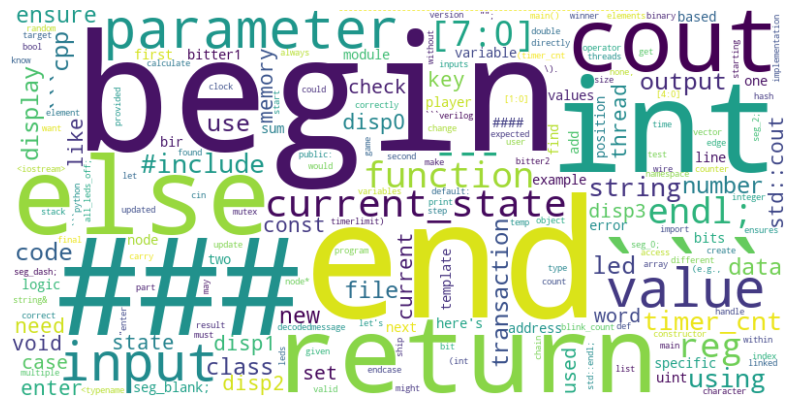

Word cloud successfully generated, excluding stopwords.


In [41]:
import csv
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already present
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Read CSV and extract messages
all_chats = []
with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        all_chats.append(row['Message'])

# Generate word frequency
word_count = defaultdict(int)
for chat in all_chats:
    words = chat.split()
    for word in words:
        word = word.lower()
        if word not in stop_words and len(word) > 2:  # Exclude stopwords and short words
            word_count[word] += 1

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_count)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

print("Word cloud successfully generated, excluding stopwords.")


# **Average Conversation Length**
### Conversation length is the total characters used by me and AI agent in the given period of time

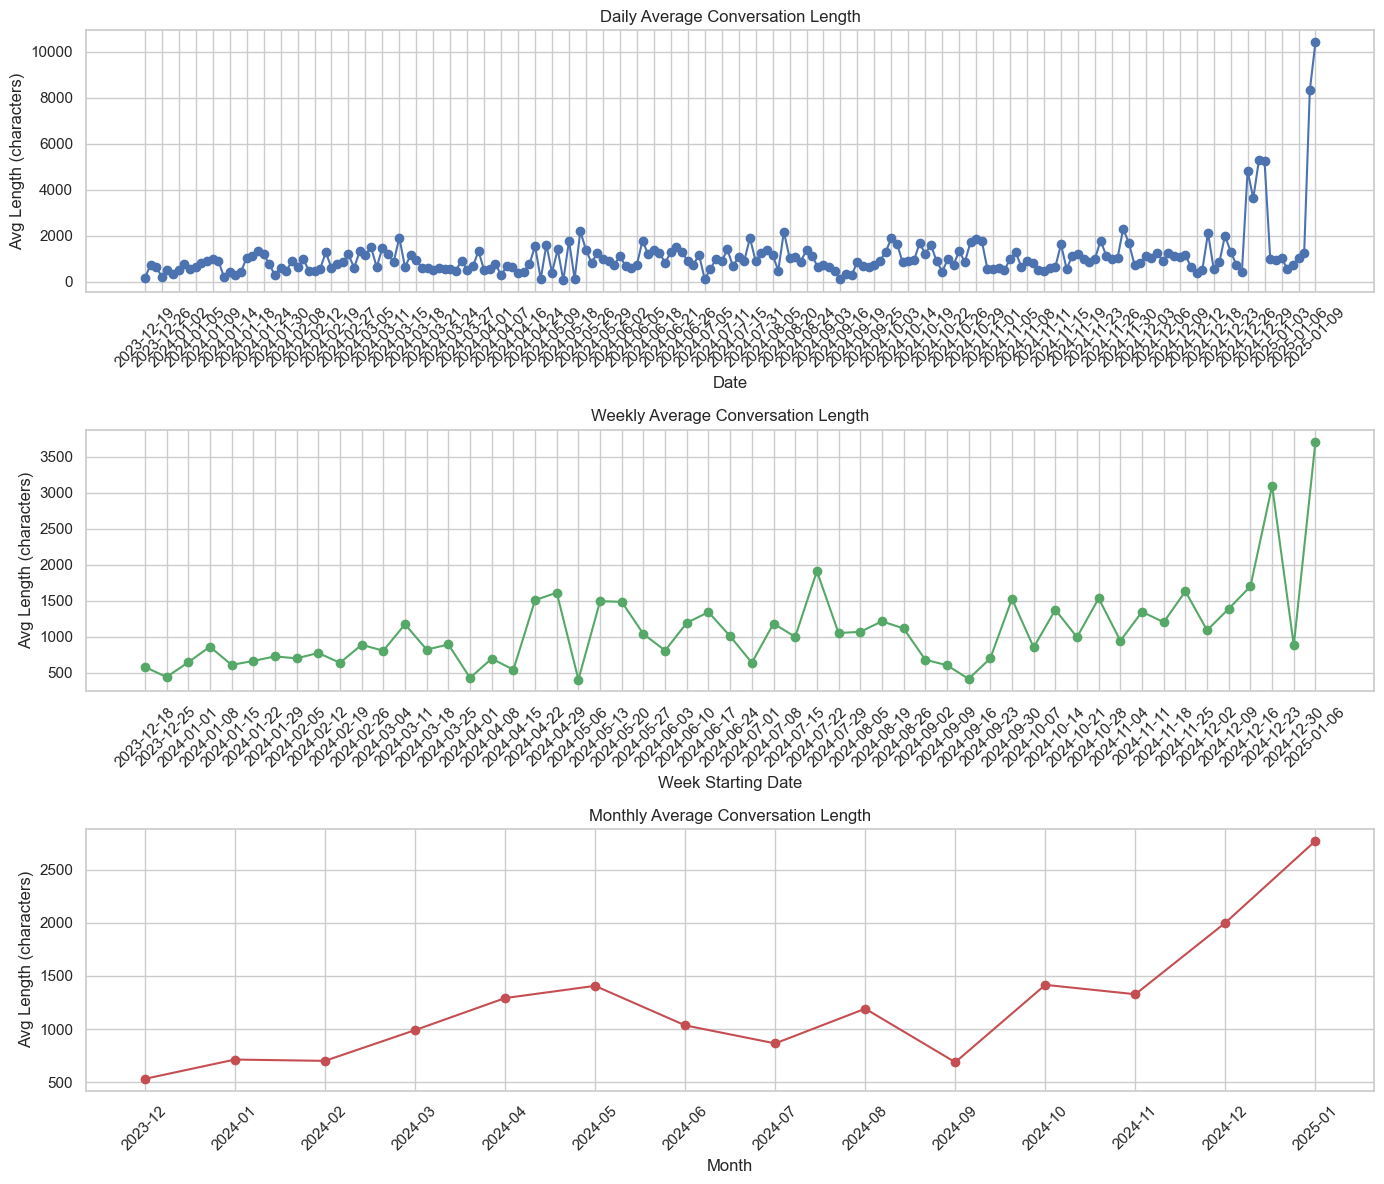

Daily, weekly, and monthly conversation length graphs successfully generated.


In [42]:
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict

# Initialize dictionaries for daily, weekly, and monthly counts and conversation lengths
daily_counts = defaultdict(int)
weekly_counts = defaultdict(int)
monthly_counts = defaultdict(int)
daily_lengths = defaultdict(int)
weekly_lengths = defaultdict(int)
monthly_lengths = defaultdict(int)

# Read CSV and extract timestamps and conversation lengths
with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        timestamp = row['Timestamp']
        timestamp = timestamp.replace(' UTC', '')  # Remove UTC suffix
        dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        length = len(row['Message'])  # Conversation length based on message length
        
        # Daily count and length
        date_str = dt.date().strftime('%Y-%m-%d')
        daily_counts[date_str] += 1
        daily_lengths[date_str] += length
        
        # Weekly count and length (get Monday of the week)
        week_start = (dt - timedelta(days=dt.weekday())).date()
        week_str = week_start.strftime('%Y-%m-%d')
        weekly_counts[week_str] += 1
        weekly_lengths[week_str] += length
        
        # Monthly count and length
        month_str = dt.strftime('%Y-%m')
        monthly_counts[month_str] += 1
        monthly_lengths[month_str] += length

# Sort data
sorted_days = sorted(daily_counts.keys())
sorted_daily_lengths = [daily_lengths[day] / daily_counts[day] for day in sorted_days]  # Average length per day

sorted_weeks = sorted(weekly_counts.keys())
sorted_weekly_lengths = [weekly_lengths[week] / weekly_counts[week] for week in sorted_weeks]  # Average length per week

sorted_months = sorted(monthly_counts.keys())
sorted_monthly_lengths = [monthly_lengths[month] / monthly_counts[month] for month in sorted_months]  # Average length per month

# Plot using GridSpec
plt.figure(figsize=(14, 12))
gs = GridSpec(3, 1, height_ratios=[1, 1, 1])

# Daily Plot
ax0 = plt.subplot(gs[0])
ax0.plot(sorted_days, sorted_daily_lengths, marker='o', linestyle='-', color='b')
ax0.set_title("Daily Average Conversation Length")
ax0.set_xlabel("Date")
ax0.set_ylabel("Avg Length (characters)")
ax0.grid(True)

# Show only every third day's label
ax0.set_xticks(sorted_days[::3])  # Skip every two days
ax0.tick_params(axis='x', rotation=45)

# Weekly Plot
ax1 = plt.subplot(gs[1])
ax1.plot(sorted_weeks, sorted_weekly_lengths, marker='o', linestyle='-', color='g')
ax1.set_title("Weekly Average Conversation Length")
ax1.set_xlabel("Week Starting Date")
ax1.set_ylabel("Avg Length (characters)")
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Monthly Plot
ax2 = plt.subplot(gs[2])
ax2.plot(sorted_months, sorted_monthly_lengths, marker='o', linestyle='-', color='r')
ax2.set_title("Monthly Average Conversation Length")
ax2.set_xlabel("Month")
ax2.set_ylabel("Avg Length (characters)")
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Daily, weekly, and monthly conversation length graphs successfully generated.")



# **Average Conversation Frequency**

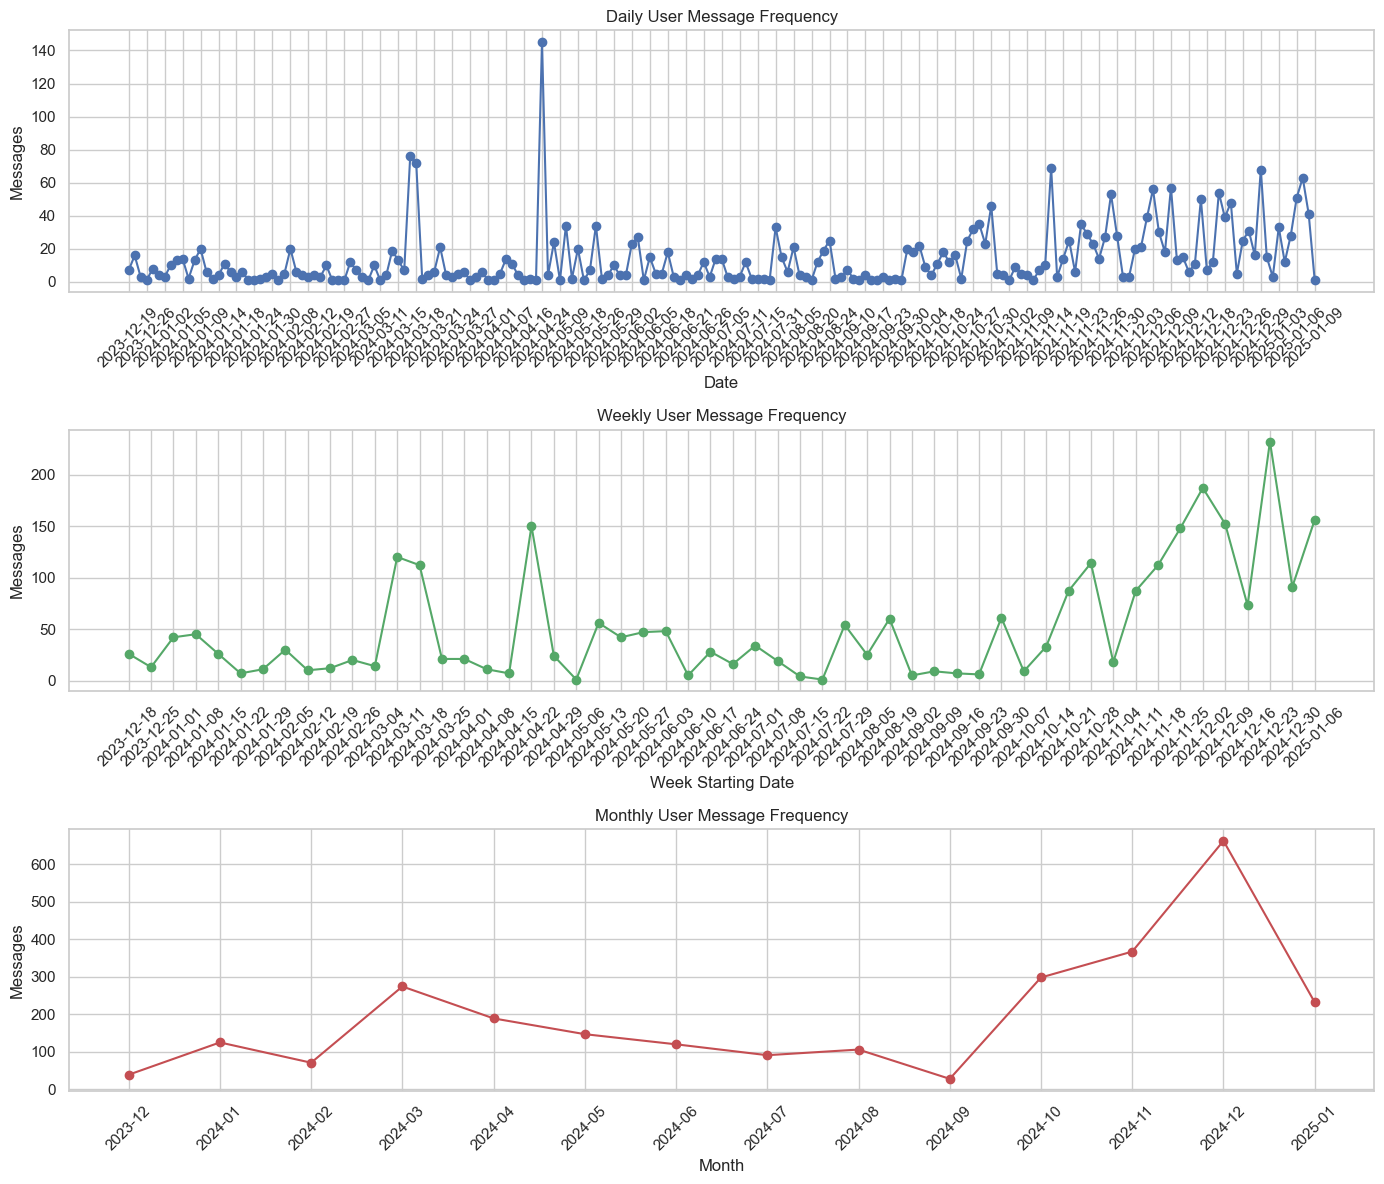

Daily, weekly, and monthly user message frequency graphs successfully generated.


In [43]:
import csv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict

# Initialize dictionaries for daily, weekly, and monthly counts of user messages
daily_counts = defaultdict(int)
weekly_counts = defaultdict(int)
monthly_counts = defaultdict(int)

# Read CSV and extract timestamps and filter user inputs
with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['Sender'].lower() == 'user':  # Count only user inputs
            timestamp = row['Timestamp']
            timestamp = timestamp.replace(' UTC', '')  # Remove UTC suffix
            dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
            
            # Daily count
            date_str = dt.date().strftime('%Y-%m-%d')
            daily_counts[date_str] += 1
            
            # Weekly count (get Monday of the week)
            week_start = (dt - timedelta(days=dt.weekday())).date()
            week_str = week_start.strftime('%Y-%m-%d')
            weekly_counts[week_str] += 1
            
            # Monthly count
            month_str = dt.strftime('%Y-%m')
            monthly_counts[month_str] += 1

# Sort data
sorted_days = sorted(daily_counts.keys())
sorted_daily_counts = [daily_counts[day] for day in sorted_days]

sorted_weeks = sorted(weekly_counts.keys())
sorted_weekly_counts = [weekly_counts[week] for week in sorted_weeks]

sorted_months = sorted(monthly_counts.keys())
sorted_monthly_counts = [monthly_counts[month] for month in sorted_months]

# Plot using GridSpec
plt.figure(figsize=(14, 12))
gs = GridSpec(3, 1, height_ratios=[1, 1, 1])

# Daily Plot
ax0 = plt.subplot(gs[0])
ax0.plot(sorted_days, sorted_daily_counts, marker='o', linestyle='-', color='b')
ax0.set_title("Daily User Message Frequency")
ax0.set_xlabel("Date")
ax0.set_ylabel("Messages")
ax0.grid(True)

# Show only every third day's label
ax0.set_xticks(sorted_days[::3])  # Skip every two days
ax0.tick_params(axis='x', rotation=45)

# Weekly Plot
ax1 = plt.subplot(gs[1])
ax1.plot(sorted_weeks, sorted_weekly_counts, marker='o', linestyle='-', color='g')
ax1.set_title("Weekly User Message Frequency")
ax1.set_xlabel("Week Starting Date")
ax1.set_ylabel("Messages")
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Monthly Plot
ax2 = plt.subplot(gs[2])
ax2.plot(sorted_months, sorted_monthly_counts, marker='o', linestyle='-', color='r')
ax2.set_title("Monthly User Message Frequency")
ax2.set_xlabel("Month")
ax2.set_ylabel("Messages")
ax2.grid(True)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("Daily, weekly, and monthly user message frequency graphs successfully generated.")


# Commercial Break: Paying ChatGPT really works.
### I bought ChatGPT+ on 12-21-2024 and my data drastically changed: while my message frequency decreased (you normally wait for average conversation length to decrease) my conversation length increased since I could be able to use better models for more time and get better answers.

=== Descriptive Statistics ===
Frequency (Before 2024-12-21): mean=30.48, std=40.84, n=191 days
Frequency (After  2024-12-21): mean=92.94, std=65.46, n=17 days
Avg Length (Before 2024-12-21): mean=918.90, std=450.86, n=191 days
Avg Length (After  2024-12-21): mean=2868.55, std=2979.94, n=17 days

=== T-Test: Frequency (Before vs. After) ===
T-statistic = -3.868, p-value = 0.001219

=== T-Test: Avg Conversation Length (Before vs. After) ===
T-statistic = -2.695, p-value = 0.015898

=== Correlation Results ===
Correlation(Purchase Dummy, Daily Frequency)          = 0.369
Correlation(Purchase Dummy, Daily Average Length)     = 0.497



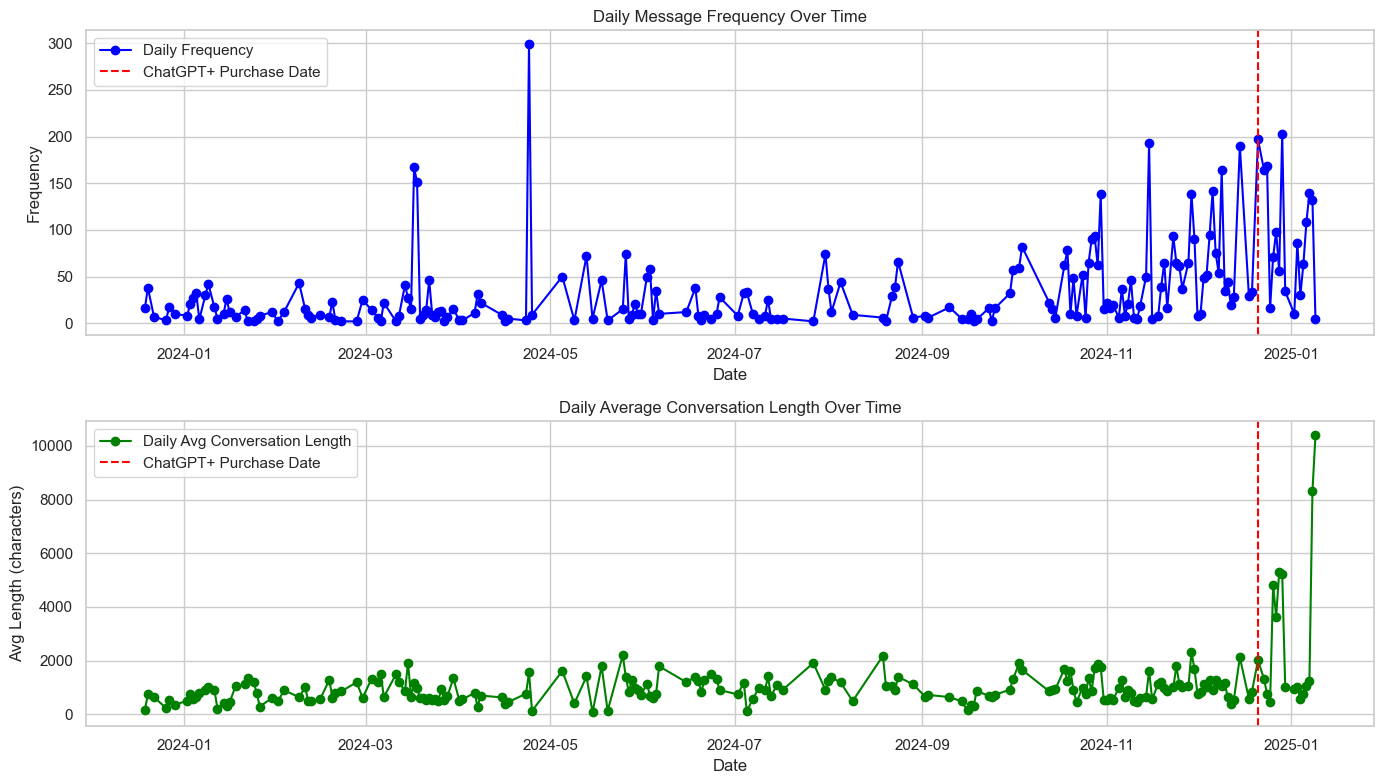

In [52]:
import csv
from datetime import datetime, timedelta
from collections import defaultdict

import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# -----------------------------
# CONFIGURATION
# -----------------------------
CSV_FILENAME = 'consolidated_chat_history.csv'
DATE_FORMAT = '%Y-%m-%d %H:%M:%S'  # Adjust if your CSV uses a different format
PURCHASE_DATE_STR = '2024-12-21'   # Date you purchased ChatGPT+
PURCHASE_DATE = datetime.strptime(PURCHASE_DATE_STR, '%Y-%m-%d')

# -----------------------------
# STEP 1: READ AND AGGREGATE DATA (DAILY)
# -----------------------------
daily_counts = defaultdict(int)    # How many messages each day
daily_lengths = defaultdict(int)   # Total characters each day (to compute average)

with open(CSV_FILENAME, 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        timestamp_str = row['Timestamp'].replace(' UTC', '')  # remove " UTC"
        dt = datetime.strptime(timestamp_str, DATE_FORMAT)
        
        # Convert datetime to just the date (YYYY-MM-DD) string
        day_str = dt.strftime('%Y-%m-%d')
        
        # Count how many messages in total (regardless of sender or just user, your choice)
        # If you want only user messages, uncomment the next line:
        # if row['Sender'].lower() != 'user':
        #     continue

        # Increase daily frequency
        daily_counts[day_str] += 1
        
        # Add to daily total length
        message_length = len(row['Message'])
        daily_lengths[day_str] += message_length

# Convert daily_counts to sorted lists (by chronological date)
sorted_days_str = sorted(daily_counts.keys(), key=lambda x: datetime.strptime(x, '%Y-%m-%d'))
sorted_dates = [datetime.strptime(day_str, '%Y-%m-%d') for day_str in sorted_days_str]

# Prepare lists for plotting and correlation
daily_frequency_list = []
daily_avg_length_list = []

for day_str in sorted_days_str:
    freq = daily_counts[day_str]
    avg_len = daily_lengths[day_str] / freq  # average length = total length / number of messages
    daily_frequency_list.append(freq)
    daily_avg_length_list.append(avg_len)

# -----------------------------
# STEP 2: SPLIT DATA BEFORE VS. AFTER PURCHASE DATE
# -----------------------------
before_freq = []
after_freq = []
before_len = []
after_len = []

# Also prepare a dummy variable (0 = before, 1 = on/after purchase) for correlation
purchase_dummy = []
for day_str, freq, avg_len in zip(sorted_days_str, daily_frequency_list, daily_avg_length_list):
    current_date = datetime.strptime(day_str, '%Y-%m-%d')
    if current_date < PURCHASE_DATE:
        before_freq.append(freq)
        before_len.append(avg_len)
        purchase_dummy.append(0)
    else:
        after_freq.append(freq)
        after_len.append(avg_len)
        purchase_dummy.append(1)

before_freq = np.array(before_freq)
after_freq = np.array(after_freq)
before_len = np.array(before_len)
after_len = np.array(after_len)
purchase_dummy = np.array(purchase_dummy)

# -----------------------------
# STEP 3: BASIC STATISTICS
# -----------------------------
mean_freq_before = np.mean(before_freq) if len(before_freq) > 0 else 0
std_freq_before = np.std(before_freq, ddof=1) if len(before_freq) > 1 else 0
mean_freq_after = np.mean(after_freq) if len(after_freq) > 0 else 0
std_freq_after = np.std(after_freq, ddof=1) if len(after_freq) > 1 else 0

mean_len_before = np.mean(before_len) if len(before_len) > 0 else 0
std_len_before = np.std(before_len, ddof=1) if len(before_len) > 1 else 0
mean_len_after = np.mean(after_len) if len(after_len) > 0 else 0
std_len_after = np.std(after_len, ddof=1) if len(after_len) > 1 else 0

# -----------------------------
# STEP 4: T-TEST (BEFORE VS. AFTER)
# -----------------------------
freq_ttest_result = ttest_ind(before_freq, after_freq, equal_var=False) if len(before_freq) > 1 and len(after_freq) > 1 else None
len_ttest_result = ttest_ind(before_len, after_len, equal_var=False) if len(before_len) > 1 and len(after_len) > 1 else None

# -----------------------------
# STEP 5: CORRELATION
# -----------------------------
# purchase_dummy is 0 before purchase, 1 on/after purchase
# daily_frequency_list and daily_avg_length_list store *all* data in chronological order
freq_correlation = np.corrcoef(purchase_dummy, daily_frequency_list)[0, 1]
len_correlation = np.corrcoef(purchase_dummy, daily_avg_length_list)[0, 1]

# -----------------------------
# PRINT STATISTICAL FINDINGS
# -----------------------------
print("=== Descriptive Statistics ===")
print(f"Frequency (Before {PURCHASE_DATE_STR}): mean={mean_freq_before:.2f}, std={std_freq_before:.2f}, n={len(before_freq)} days")
print(f"Frequency (After  {PURCHASE_DATE_STR}): mean={mean_freq_after:.2f}, std={std_freq_after:.2f}, n={len(after_freq)} days")
print(f"Avg Length (Before {PURCHASE_DATE_STR}): mean={mean_len_before:.2f}, std={std_len_before:.2f}, n={len(before_len)} days")
print(f"Avg Length (After  {PURCHASE_DATE_STR}): mean={mean_len_after:.2f}, std={std_len_after:.2f}, n={len(after_len)} days")
print()

if freq_ttest_result is not None:
    print("=== T-Test: Frequency (Before vs. After) ===")
    print(f"T-statistic = {freq_ttest_result.statistic:.3f}, p-value = {freq_ttest_result.pvalue:.6f}")
    print()
else:
    print("Not enough data to perform T-Test on Frequency.")
    print()

if len_ttest_result is not None:
    print("=== T-Test: Avg Conversation Length (Before vs. After) ===")
    print(f"T-statistic = {len_ttest_result.statistic:.3f}, p-value = {len_ttest_result.pvalue:.6f}")
    print()
else:
    print("Not enough data to perform T-Test on Avg Conversation Length.")
    print()

print("=== Correlation Results ===")
print(f"Correlation(Purchase Dummy, Daily Frequency)          = {freq_correlation:.3f}")
print(f"Correlation(Purchase Dummy, Daily Average Length)     = {len_correlation:.3f}")
print()

# -----------------------------
# STEP 6: PLOT THE RESULTS
# -----------------------------
# We'll create two subplots: one for Frequency, one for Average Length
plt.figure(figsize=(14, 8))

# 1) Daily Frequency Plot
plt.subplot(2, 1, 1)
plt.plot(sorted_dates, daily_frequency_list, marker='o', linestyle='-', color='blue', label='Daily Frequency')
plt.axvline(PURCHASE_DATE, color='red', linestyle='--', label='ChatGPT+ Purchase Date')
plt.title("Daily Message Frequency Over Time")
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)

# 2) Daily Average Length Plot
plt.subplot(2, 1, 2)
plt.plot(sorted_dates, daily_avg_length_list, marker='o', linestyle='-', color='green', label='Daily Avg Conversation Length')
plt.axvline(PURCHASE_DATE, color='red', linestyle='--', label='ChatGPT+ Purchase Date')
plt.title("Daily Average Conversation Length Over Time")
plt.xlabel("Date")
plt.ylabel("Avg Length (characters)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [44]:
import csv
from datetime import datetime, timedelta
from collections import defaultdict
import numpy as np

# Initialize dictionaries for daily counts and lengths
daily_counts = defaultdict(int)
daily_lengths = defaultdict(int)

# Read CSV and extract timestamps and conversation lengths
with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        timestamp = row['Timestamp']
        timestamp = timestamp.replace(' UTC', '')  # Remove UTC suffix
        dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        length = len(row['Message'])  # Conversation length based on message length

        # Daily count and length
        date_str = dt.date().strftime('%Y-%m-%d')
        daily_counts[date_str] += 1
        daily_lengths[date_str] += length

# Calculate daily averages
average_lengths = {
    day: daily_lengths[day] / daily_counts[day]
    for day in daily_counts if daily_counts[day] > 0
}

# Convert to lists for statistical calculations
daily_counts_list = list(daily_counts.values())
average_lengths_list = list(average_lengths.values())
dates_list = list(daily_counts.keys())

# Calculate statistical thresholds for outliers
count_mean = np.mean(daily_counts_list)
count_std = np.std(daily_counts_list)

length_mean = np.mean(average_lengths_list)
length_std = np.std(average_lengths_list)

count_threshold_high = count_mean + 3 * count_std
length_threshold_high = length_mean + 3 * length_std

# Identify outlier days based on thresholds
outlier_days_count = [
    date for date, count in daily_counts.items()
    if count > count_threshold_high
]

outlier_days_length = [
    date for date, avg_length in average_lengths.items()
    if avg_length > length_threshold_high
]

# Print results
print("Outlier Days by Conversation Count (High Activity):")
for date in outlier_days_count:
    print(f"Date: {date}, Count: {daily_counts[date]}")

print("\nOutlier Days by Average Conversation Length (Unusually Long Conversations):")
for date in outlier_days_length:
    print(f"Date: {date}, Avg Length: {average_lengths[date]:.2f} characters")


Outlier Days by Conversation Count (High Activity):
Date: 2024-04-24, Count: 299
Date: 2024-11-15, Count: 193
Date: 2024-12-15, Count: 190
Date: 2024-12-21, Count: 197
Date: 2024-12-29, Count: 203

Outlier Days by Average Conversation Length (Unusually Long Conversations):
Date: 2024-12-26, Avg Length: 4823.62 characters
Date: 2024-12-28, Avg Length: 5286.29 characters
Date: 2024-12-29, Avg Length: 5230.62 characters
Date: 2025-01-08, Avg Length: 8314.89 characters
Date: 2025-01-09, Avg Length: 10401.50 characters


These were on the outlier days:

CS201,HW3,2024-04-24 00:00:00,2024-04-24

CS303,Lab2,2024-11-15 00:00:00,2024-11-15

CS204,HW6,2024-12-15 00:00:00,2024-12-15

CS303,Project Phase 2,2024-12-24 00:00:00,2024-12-24

General exam preperation: 2024-12-29 

#### I believe AI agents are invaluable tools that significantly accelerate the processes of learning and acquiring knowledge.

# **HEATMAPS**

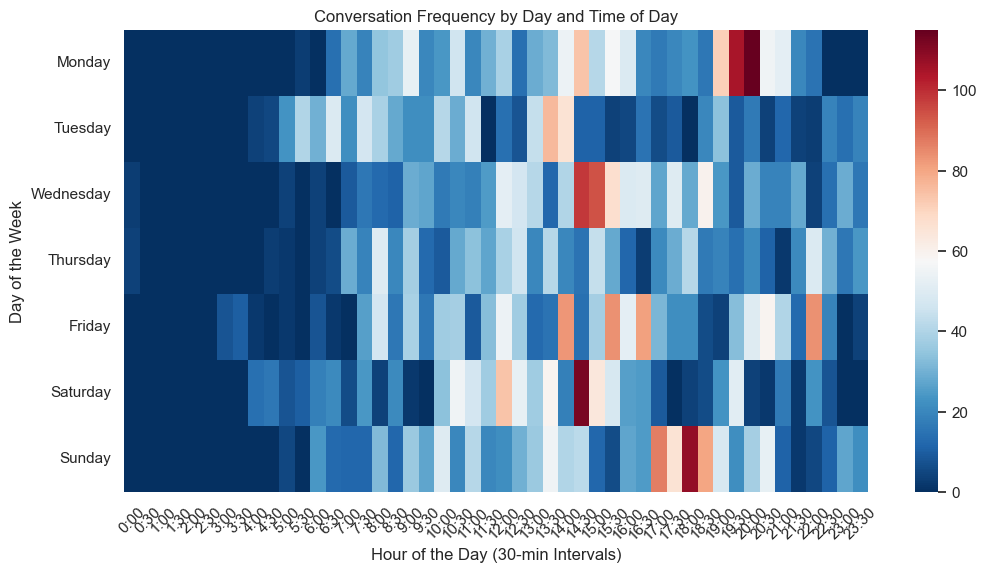

Heatmap successfully generated.


In [45]:
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize array for day-hour counts
hour_counts = np.zeros((7, 48))  # 7 days, 48 slots for 30-minute intervals

# Read CSV and extract timestamps
with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        timestamp = row['Timestamp']
        timestamp = timestamp.replace(' UTC', '')  # Remove UTC suffix
        dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        day_of_week = dt.weekday()  # Monday = 0, Sunday = 6
        hour_slot = dt.hour * 2 + (dt.minute // 30)  # Map to 30-min slot
        hour_counts[day_of_week][hour_slot] += 1

# Prepare heatmap data
hour_labels = [f"{h//2}:{'00' if h%2 == 0 else '30'}" for h in range(48)]
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(hour_counts, annot=False, cmap="RdBu_r", xticklabels=hour_labels, yticklabels=day_labels)
plt.xticks(rotation=45)
plt.title("Conversation Frequency by Day and Time of Day")
plt.xlabel("Hour of the Day (30-min Intervals)")
plt.ylabel("Day of the Week")
plt.show()

print("Heatmap successfully generated.")




There is a heatmap of frequency with 30 minute intervals

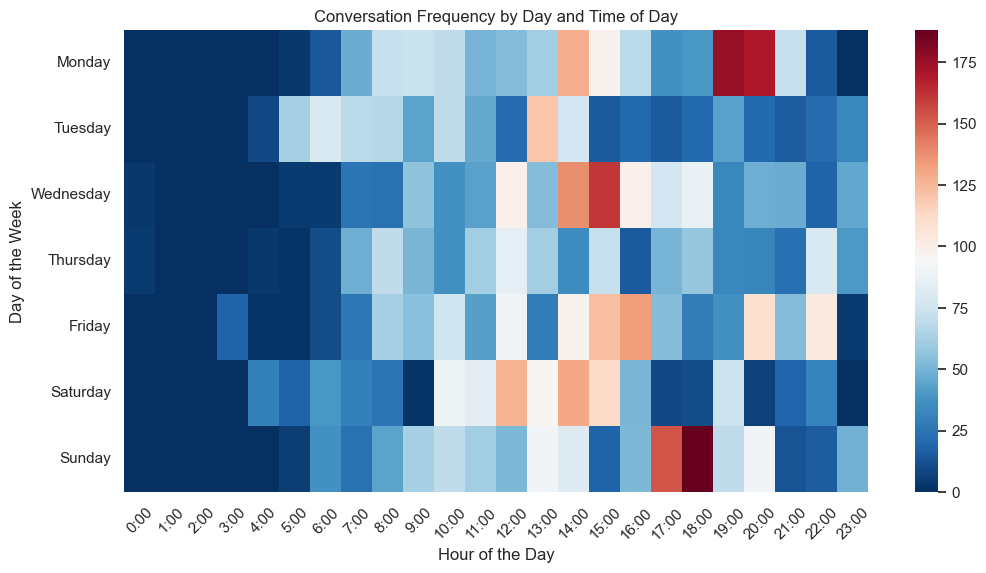

Heatmap successfully generated.


In [46]:
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize array for day-hour counts
hour_counts = np.zeros((7, 24))  # 7 days, 24 slots for hourly intervals

# Read CSV and extract timestamps
with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        timestamp = row['Timestamp']
        timestamp = timestamp.replace(' UTC', '')  # Remove UTC suffix
        dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        day_of_week = dt.weekday()  # Monday = 0, Sunday = 6
        hour_slot = dt.hour  # Map to hourly slot
        hour_counts[day_of_week][hour_slot] += 1

# Prepare heatmap data
hour_labels = [f"{h}:00" for h in range(24)]
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(hour_counts, annot=False, cmap="RdBu_r", xticklabels=hour_labels, yticklabels=day_labels)
plt.xticks(rotation=45)
plt.title("Conversation Frequency by Day and Time of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()

print("Heatmap successfully generated.")


Usage frequency with 1 hour intervals

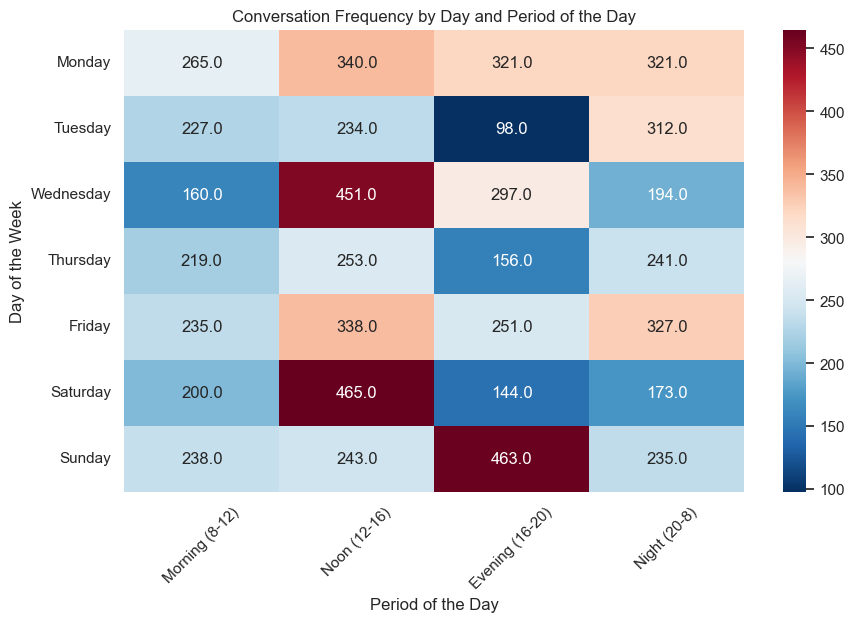

Heatmap successfully generated.


In [47]:
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize array for day-period counts
period_counts = np.zeros((7, 4))  # 7 days, 4 periods (morning, noon, evening, night)

# Read CSV and extract timestamps
with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        timestamp = row['Timestamp']
        timestamp = timestamp.replace(' UTC', '')  # Remove UTC suffix
        dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        day_of_week = dt.weekday()  # Monday = 0, Sunday = 6
        hour = dt.hour
        
        # Map hours to periods
        if 8 <= hour < 12:
            period = 0  # Morning
        elif 12 <= hour < 16:
            period = 1  # Noon
        elif 16 <= hour < 20:
            period = 2  # Evening
        else:
            period = 3  # Night
        
        period_counts[day_of_week][period] += 1

# Prepare heatmap data
period_labels = ["Morning (8-12)", "Noon (12-16)", "Evening (16-20)", "Night (20-8)"]
day_labels = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(period_counts, annot=True, fmt=".1f", cmap="RdBu_r", xticklabels=period_labels, yticklabels=day_labels)
plt.xticks(rotation=45)
plt.title("Conversation Frequency by Day and Period of the Day")
plt.xlabel("Period of the Day")
plt.ylabel("Day of the Week")
plt.show()

print("Heatmap successfully generated.")


# Correlation Between the Usage of AI Agents During Exam and Assignment Periods Versus Non-Exam and Non-Assignment Periods

Average messages during assignment periods: 21.71
Average messages during non-assignment periods: 7.16
T-test results: t-statistic = 5.73, p-value = 0.000000
There is a statistically significant difference in AI agent usage between assignment and non-assignment periods.


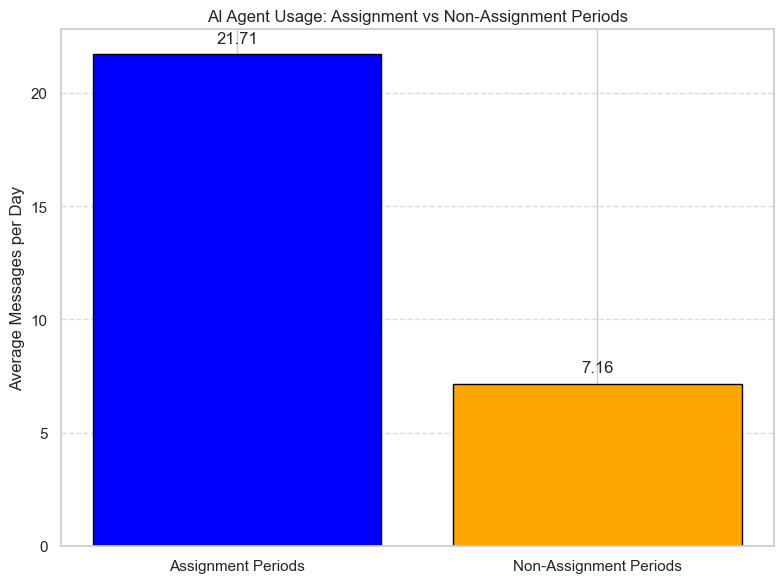

In [48]:
import csv
from datetime import datetime, timedelta
from collections import defaultdict
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

daily_counts = defaultdict(int)

with open('consolidated_chat_history.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['Sender'].lower() == 'user':
            timestamp = row['Timestamp'].replace(' UTC', '')
            dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
            date_str = dt.date().strftime('%Y-%m-%d')
            daily_counts[date_str] += 1

assignment_periods = set()

with open('updated_exam_schedule.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, fieldnames=["Course", "ExamType", "DateTime", "Date"])
    next(reader)  # Skip header
    for row in reader:
        event_date = datetime.strptime(row["Date"], "%Y-%m-%d").date()
        for i in range(7):
            assignment_periods.add((event_date - timedelta(days=i)).strftime("%Y-%m-%d"))

assignment_messages = []
non_assignment_messages = []

for date, count in daily_counts.items():
    if date in assignment_periods:
        assignment_messages.append(count)
    else:
        non_assignment_messages.append(count)

avg_assignment = sum(assignment_messages) / len(assignment_messages) if assignment_messages else 0
avg_non_assignment = sum(non_assignment_messages) / len(non_assignment_messages) if non_assignment_messages else 0

t_stat, p_value = ttest_ind(assignment_messages, non_assignment_messages, equal_var=False)

print(f"Average messages during assignment periods: {avg_assignment:.2f}")
print(f"Average messages during non-assignment periods: {avg_non_assignment:.2f}")
print(f"T-test results: t-statistic = {t_stat:.2f}, p-value = {p_value:.6f}")

if p_value < 0.05:
    print("There is a statistically significant difference in AI agent usage between assignment and non-assignment periods.")
else:
    print("There is no statistically significant difference in AI agent usage between assignment and non-assignment periods.")

# Plotting the Comparison
labels = ['Assignment Periods', 'Non-Assignment Periods']
averages = [avg_assignment, avg_non_assignment]

plt.figure(figsize=(8, 6))
plt.bar(labels, averages, color=['blue', 'orange'], edgecolor='black')
plt.title('AI Agent Usage: Assignment vs Non-Assignment Periods')
plt.ylabel('Average Messages per Day')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate the bars with values
for i, avg in enumerate(averages):
    plt.text(i, avg + 0.5, f"{avg:.2f}", ha='center', fontsize=12)

plt.tight_layout()
plt.show()


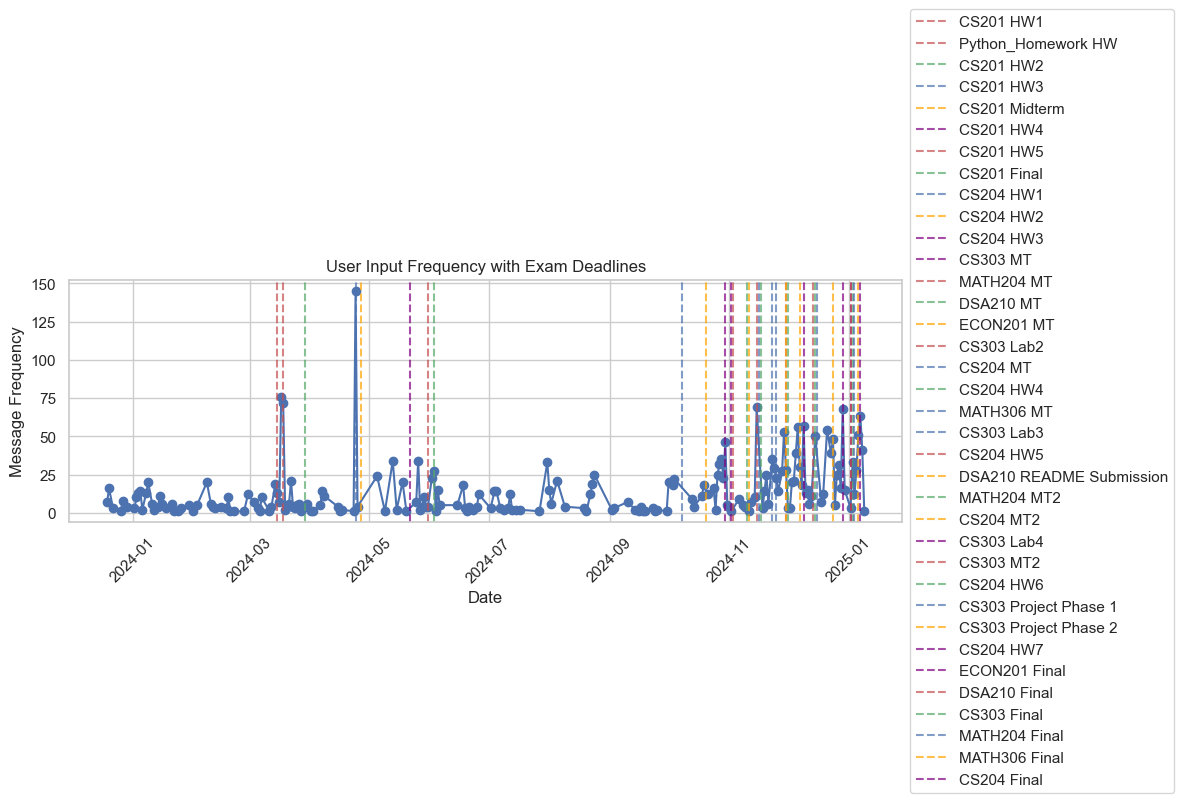

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Load CSV files with raw string paths
chat_history = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\consolidated_chat_history.csv')
exam_schedule = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\updated_exam_schedule.csv')

# Convert timestamp to datetime in chat history
chat_history['Timestamp'] = pd.to_datetime(chat_history['Timestamp'])

# Filter only user messages
user_messages = chat_history[chat_history['Sender'] == 'user']

# Start from the earliest chat entry
start_date = user_messages['Timestamp'].min().date()

# Group by date to get daily user input frequency
user_frequency = user_messages.groupby(user_messages['Timestamp'].dt.date).size()

# Convert exam date to datetime
exam_schedule['Date'] = pd.to_datetime(exam_schedule['Date'])

# Sort exam deadlines chronologically
exam_schedule = exam_schedule.sort_values(by='Date')

# Plot user input frequency
plt.figure(figsize=(12, 6))
plt.plot(user_frequency.index, user_frequency.values, marker='o', label='User Input Frequency')

# Plot exam deadlines as vertical lines with labels
colors = ['r', 'g', 'b', 'orange', 'purple']
handles = []
labels = []

for i, row in exam_schedule.iterrows():
    if row['Date'].date() >= start_date:
        line = plt.axvline(row['Date'], color=colors[i % len(colors)], linestyle='--', alpha=0.7)
        handles.append(line)
        labels.append(f"{row['Course']} {row['Exam Type']}")

# Sort legend by date
sorted_indices = sorted(range(len(labels)), key=lambda k: exam_schedule.iloc[k]['Date'])
sorted_handles = [handles[i] for i in sorted_indices]
sorted_labels = [labels[i] for i in sorted_indices]

plt.legend(sorted_handles, sorted_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Date')
plt.ylabel('Message Frequency')
plt.title('User Input Frequency with Exam Deadlines')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





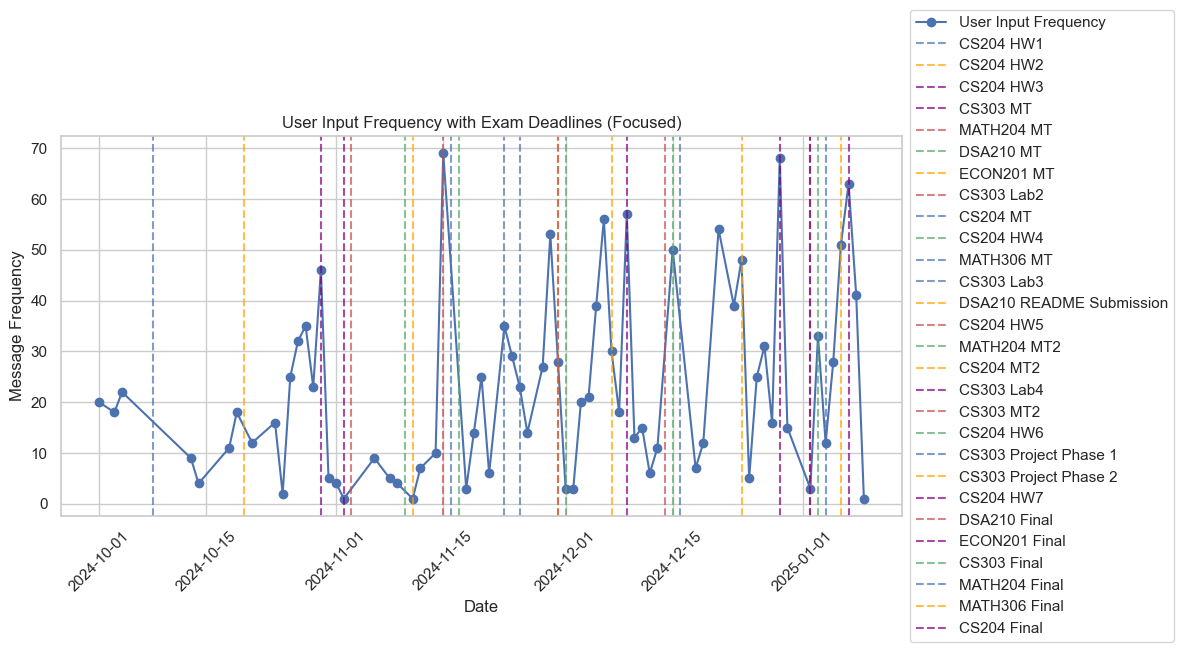

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Load CSV files with raw string paths
chat_history = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\consolidated_chat_history.csv')
exam_schedule = pd.read_csv(r'C:\Users\AYB\Desktop\PromtAnalyze_DSA210\updated_exam_schedule.csv')

# Convert timestamp to datetime in chat history
chat_history['Timestamp'] = pd.to_datetime(chat_history['Timestamp'])

# Filter only user messages
user_messages = chat_history[chat_history['Sender'] == 'user']

# Start from the earliest chat entry
start_date = user_messages['Timestamp'].min().date()

# Group by date to get daily user input frequency
user_frequency = user_messages.groupby(user_messages['Timestamp'].dt.date).size()

# Convert exam date to datetime
exam_schedule['Date'] = pd.to_datetime(exam_schedule['Date'])

# Focus on the period starting from October 2024 to the present
focus_start_date = datetime(2024, 10, 1).date()
filtered_frequency = user_frequency[user_frequency.index >= focus_start_date]
filtered_exam_schedule = exam_schedule[exam_schedule['Date'].dt.date >= focus_start_date]

# Sort exam deadlines chronologically
filtered_exam_schedule = filtered_exam_schedule.sort_values(by='Date')

# Plot user input frequency
plt.figure(figsize=(12, 6))
plt.plot(filtered_frequency.index, filtered_frequency.values, marker='o', label='User Input Frequency')

# Plot exam deadlines as vertical lines with labels
colors = ['r', 'g', 'b', 'orange', 'purple']
for i, row in filtered_exam_schedule.iterrows():
    plt.axvline(row['Date'], color=colors[i % len(colors)], linestyle='--', alpha=0.7, 
                label=f"{row['Course']} {row['Exam Type']}")

plt.xlabel('Date')
plt.ylabel('Message Frequency')
plt.title('User Input Frequency with Exam Deadlines (Focused)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





# Correlation Between Daily AI Usage and Using "Bad Words" in Chat
#### I am analyzing whether there is a pattern between the days I used inappropriate language with AI and my daily AI chat frequency.

Correlation between daily usage and bad word usage: 0.61


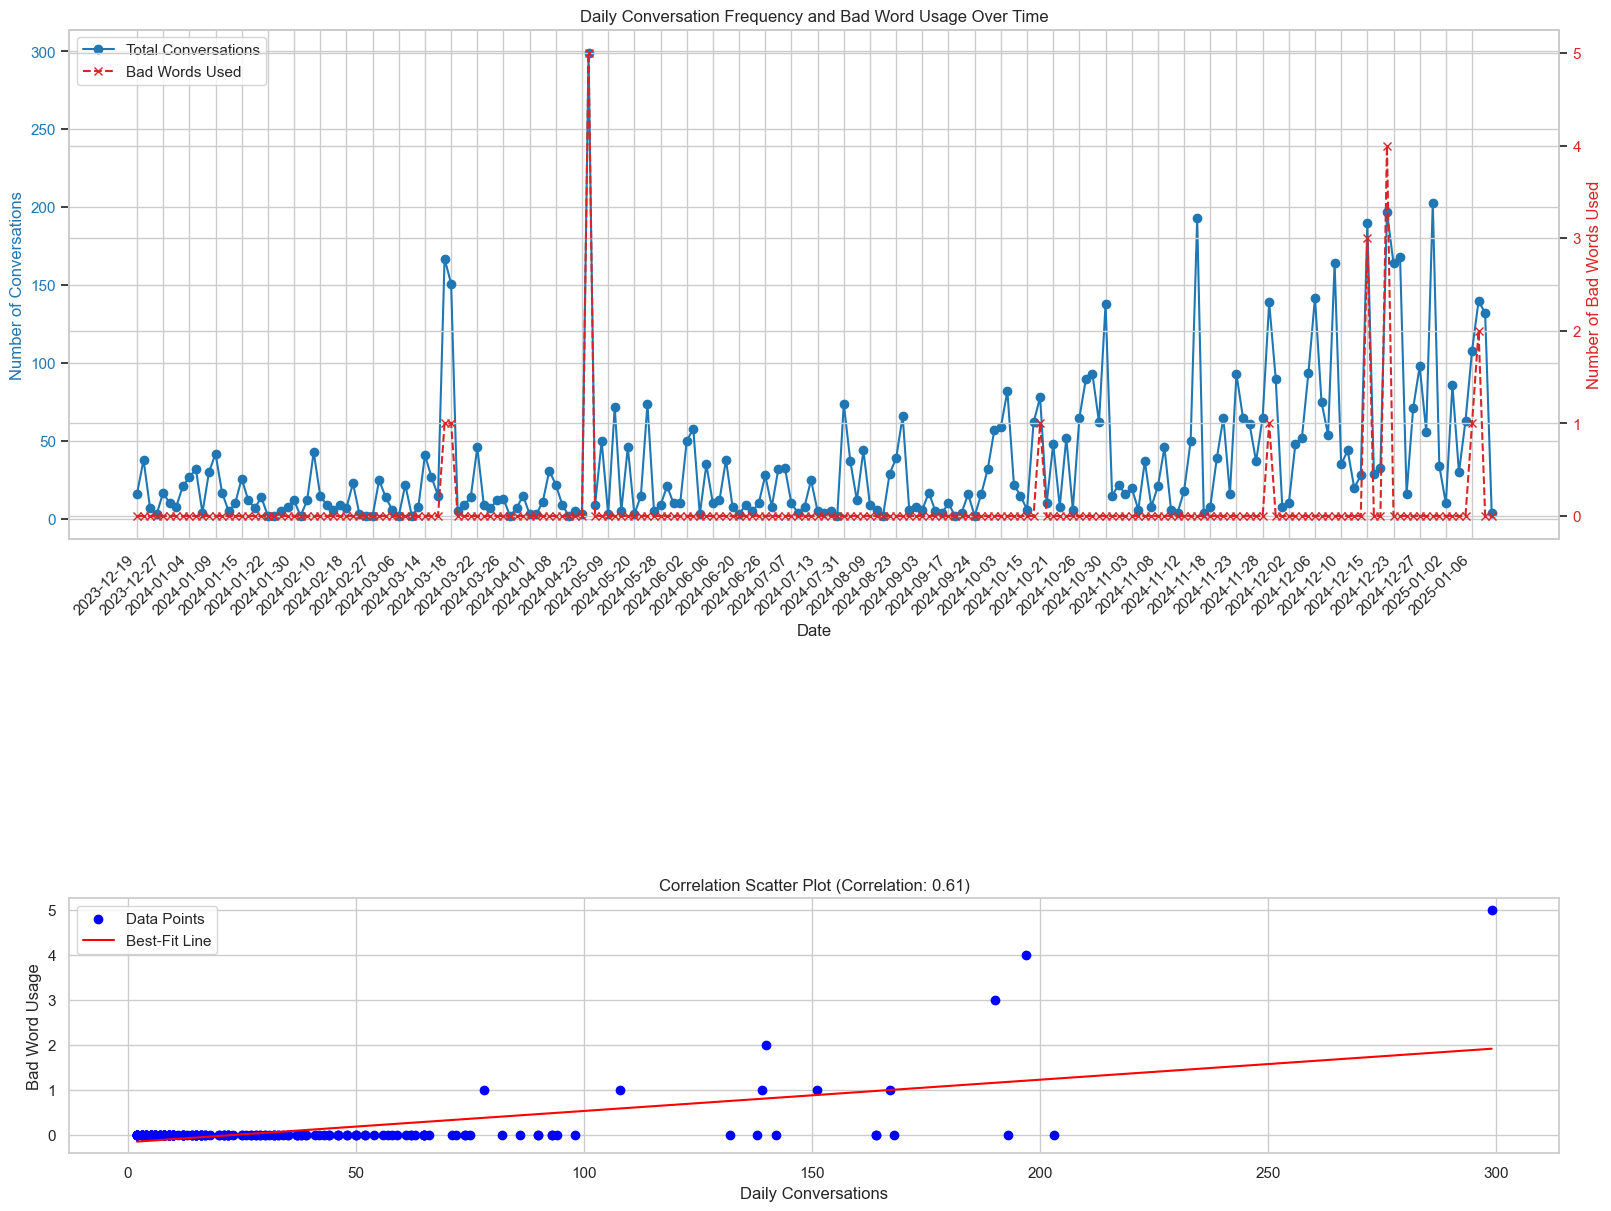

Analysis completed and graphs successfully generated.


In [51]:
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from collections import defaultdict
import re
import numpy as np

# Define list of bad words and their common typos
BAD_WORDS = [
    'dumb', 'fuck', 'dumbfuck',
    # Add common typos or variations
    'dumbfck', 'fck', 'dfuck', 'dumbfuk', 'fucky',
    'shit', 'sh1t', 's1hit', 'sh!t', 'shitt', 'shitt1', 'sh1tt'
]

# Compile regex patterns for bad words (case-insensitive)
bad_word_patterns = [re.compile(r'\b' + re.escape(word) + r'\b', re.IGNORECASE) for word in BAD_WORDS]

# Initialize dictionaries for daily counts
daily_counts = defaultdict(int)
bad_word_counts = defaultdict(int)

# Read CSV and extract timestamps and messages
csv_filename = 'consolidated_chat_history.csv'  # Ensure this file is in your working directory
with open(csv_filename, 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        timestamp = row.get('Timestamp', '')
        message = row.get('Message', '')  # Adjust the key if your message column has a different name

        if not timestamp:
            continue  # Skip rows without a timestamp

        # Remove ' UTC' if present
        timestamp = timestamp.replace(' UTC', '')

        # Convert to datetime
        try:
            dt = datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S')
        except ValueError:
            try:
                dt = datetime.fromisoformat(timestamp)
            except ValueError:
                print(f"Unrecognized timestamp format: {timestamp}")
                continue  # Skip rows with unrecognized timestamp formats

        date_str = dt.date().strftime('%Y-%m-%d')
        daily_counts[date_str] += 1

        # Check for bad words in the message
        for pattern in bad_word_patterns:
            if pattern.search(message):
                bad_word_counts[date_str] += 1
                break  # Count only once per message

# Sort dates
sorted_dates = sorted(daily_counts.keys())
sorted_counts = [daily_counts[date] for date in sorted_dates]
sorted_bad_counts = [bad_word_counts.get(date, 0) for date in sorted_dates]

# Calculate correlation
if len(sorted_counts) > 1:
    correlation_matrix = np.corrcoef(sorted_counts, sorted_bad_counts)
    correlation = correlation_matrix[0, 1]
    print(f"Correlation between daily usage and bad word usage: {correlation:.2f}")
else:
    correlation = None
    print("Not enough data to calculate correlation.")

# Set up a figure with constrained_layout enabled
fig = plt.figure(figsize=(16, 12), constrained_layout=True)
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0.4, figure=fig)

################################
# TOP PLOT: Daily usage over time
################################
ax_top = fig.add_subplot(gs[0, 0])

color1 = 'tab:blue'
ax_top.set_xlabel('Date')
ax_top.set_ylabel('Number of Conversations', color=color1)
line1 = ax_top.plot(sorted_dates, sorted_counts, marker='o', linestyle='-', color=color1, label='Total Conversations')
ax_top.tick_params(axis='y', labelcolor=color1)

# Show only every 4th date label on the x-axis
step = 4
tick_indices = range(0, len(sorted_dates), step)
tick_labels = [sorted_dates[i] for i in tick_indices]
ax_top.set_xticks(tick_indices)
ax_top.set_xticklabels(tick_labels, rotation=45, ha='right')

# Create a twin y-axis for bad word usage
ax_top2 = ax_top.twinx()
color2 = 'tab:red'
ax_top2.set_ylabel('Number of Bad Words Used', color=color2)
line2 = ax_top2.plot(sorted_dates, sorted_bad_counts, marker='x', linestyle='--', color=color2, label='Bad Words Used')
ax_top2.tick_params(axis='y', labelcolor=color2)

# Combine legends from both axes
lines_1, labels_1 = ax_top.get_legend_handles_labels()
lines_2, labels_2 = ax_top2.get_legend_handles_labels()
ax_top.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

ax_top.grid(True)
ax_top.set_title("Daily Conversation Frequency and Bad Word Usage Over Time")

################################
# BOTTOM PLOT: Correlation scatter + best-fit line
################################
ax_bottom = fig.add_subplot(gs[1, 0])

if correlation is not None and len(sorted_counts) > 1:
    # Scatter plot
    ax_bottom.scatter(sorted_counts, sorted_bad_counts, color='blue', label='Data Points')

    # Best-fit line
    coeffs = np.polyfit(sorted_counts, sorted_bad_counts, 1)  # [slope, intercept]
    poly = np.poly1d(coeffs)
    line_x = np.linspace(min(sorted_counts), max(sorted_counts), 100)
    line_y = poly(line_x)

    ax_bottom.plot(line_x, line_y, color='red', label='Best-Fit Line')

    ax_bottom.set_title(f"Correlation Scatter Plot (Correlation: {correlation:.2f})")
    ax_bottom.set_xlabel("Daily Conversations")
    ax_bottom.set_ylabel("Bad Word Usage")
    ax_bottom.grid(True)
    ax_bottom.legend()
else:
    ax_bottom.text(
        0.5, 0.5, 
        "Not enough data to plot correlation.",
        ha='center', va='center', transform=ax_bottom.transAxes,
        fontsize=12
    )
    ax_bottom.set_title("Correlation Plot")
    ax_bottom.set_xlabel("Daily Conversations")
    ax_bottom.set_ylabel("Bad Word Usage")

# Note: No need for fig.tight_layout() as constrained_layout=True handles it
plt.show()

print("Analysis completed and graphs successfully generated.")
